# Transfer Learning

## Some references:

- Transfer Learning with TF 2.0 (https://towardsdatascience.com/transfer-learning-with-tf-2-0-ff960901046d)
- How to Classify Photos of Dogs and Cats (with 97% accuracy) (https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)
- Models pre-trained on ImageNet (https://keras.io/applications/)

## Dataset

- Dogs vs. Cats dataset - https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau

import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

# to display confusion matrix
import seaborn as sn
import pandas as pd

## Auxiliary functions 

### Loading an image and providing a label

Note that we are scaling the inputs to a range \[-1, 1\] since this is what is expected by MobileNetV2


In [2]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == classNames

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # convert image to range [-1, 1]
    img = img * 2.0 - 1.0
    # resize the image to the desired size.
    return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### Generate the callbacks

In [3]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss',  
        min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', 
         factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]
    

### Data Visualization

In [4]:
def show_batch(image_batch, label_batch):
    columns = 6
    rows = int(BATCH_SIZE / columns + 1)
    plt.figure(figsize=(10, 2 * rows))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(rows, columns, n+1)
        plt.imshow((image_batch[n] * 0.5 + 0.5))
        plt.title(classNames[label_batch[n]==1][0])
        plt.axis('off')
        
        
def show_accuracy(labels, values): 

    fig, ax = plt.subplots()
    X = np.arange(len(values[0]))

    for i in range (len(values[0])+1):
        plt.bar(X + i , values[i], width = 0.5, label=labels[i])
    plt.ylim(top = 1.0, bottom = 0.90)
    plt.legend(loc='upper left')
    plt.xticks([])
    plt.show()     
    
    
def show_history(train, val):

    # summarize history for accuracy
    plt.plot(train)
    plt.plot(val)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

    
def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()    
    
    
def eval_and_show_confusion_matrix(model, data):
    numpy_labels = []
    numpy_images = []
    pred = []

    for images, labels in data.take(-1):  # take all batches of dataset
        numpy_images.extend(images.numpy())
        numpy_labels.extend(labels.numpy())
        pred.extend(model.predict(images.numpy()))
    
    all_labels = [np.argmax(x) for x in numpy_labels]
    all_preds = [np.argmax(x) for x in pred]
    
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

    show_confusion_matrix(conf_mat.numpy(), 2)
    
    
    
def show_misclassified(predictions, ground_truth, images, num_rows = 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    print(num_images)
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    ## rescaling image from [-1,1] to [0,1]
    plt.imshow(img * +.5 + 0.5, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')   

    
def eval_and_show_misclassified(model, test_set, rows):
    
    numpy_labels = []
    numpy_images = []
    pred = []

    for images, labels in test_set.take(-1):  # take all batches of dataset
        numpy_images.extend(images.numpy())
        numpy_labels.extend(labels.numpy())
        pred.extend(model.predict(images.numpy()))


    show_misclassified(pred, numpy_labels, numpy_images, rows)    
    

## Load the datasets 

replace the prefix and sufix with your own location of the dataset and models

In [5]:
data_prefix = 'D:/vcpi/dogsVScats/'
model_prefix = 'D:/vcpi/DL06/dogsvscats/'

### Loading

2000 images were removed from the dataset to create a test set. Hence, the full dataset has 23000 images.

Note: The default behavior of list_files is to return filenames in a non-deterministic random shuffled order.

In this notebook we are considering a training set of DATA_SET_SIZE images, split 80/20 for training/validation

In [6]:
TRAIN_ONLINE = True # if False it load weights from previously trained models. Set ot true if running for the first time

NCLASSES = 2
HEIGHT = 224
WIDTH = 224
NUM_CHANNELS = 3
BATCH_SIZE = 32
DATA_SET_SIZE = 23000 # one of 23000, 2500, 250 or 10
MODEL_NAME = 'InceptionResNetV2' # can also be MobileNetV2

In [7]:
# some variables that will be used in the notebook
TRAIN_DATA_LOCATION_PREFIX = f'{data_prefix}train{DATA_SET_SIZE}/'
VAL_DATA_LOCATION_PREFIX = f'{data_prefix}val{DATA_SET_SIZE}/'
TEST_DATA_LOCATION_PREFIX = f'{data_prefix}test/'

def create_weights_file_name(weights, fine_tune = False):
    if not fine_tune:
        return f'{model_prefix}{MODEL_NAME}_train{DATA_SET_SIZE}_{weights}_1_50_16/train/cp.ckpt'
    else:
        return f'{model_prefix}{MODEL_NAME}_train{DATA_SET_SIZE}_{weights}_1_50_16/train_ft/cp.ckpt'


In [8]:
data_dir = pathlib.Path(TRAIN_DATA_LOCATION_PREFIX)
  
classNames = np.array(os.listdir(data_dir))

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_list_set = tf.data.Dataset.list_files(f'{TRAIN_DATA_LOCATION_PREFIX}*/*.jpg')
train_set = train_list_set.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

train_set = train_set.shuffle(buffer_size = len(train_list_set))
train_set = train_set.prefetch(buffer_size=len(train_list_set))
train_set = train_set.batch(batch_size=BATCH_SIZE)


In [9]:
val_list_set = tf.data.Dataset.list_files(f'{VAL_DATA_LOCATION_PREFIX}*/*.jpg')
val_set = val_list_set.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

val_set = val_set.prefetch(buffer_size=len(val_list_set))
val_set = val_set.batch(batch_size=256)


In [10]:
test_list_set = tf.data.Dataset.list_files(f'{TEST_DATA_LOCATION_PREFIX}*/*.jpg')
test_set = test_list_set.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

test_set = test_set.batch(batch_size=256)


### Show a batch of images from the dataset

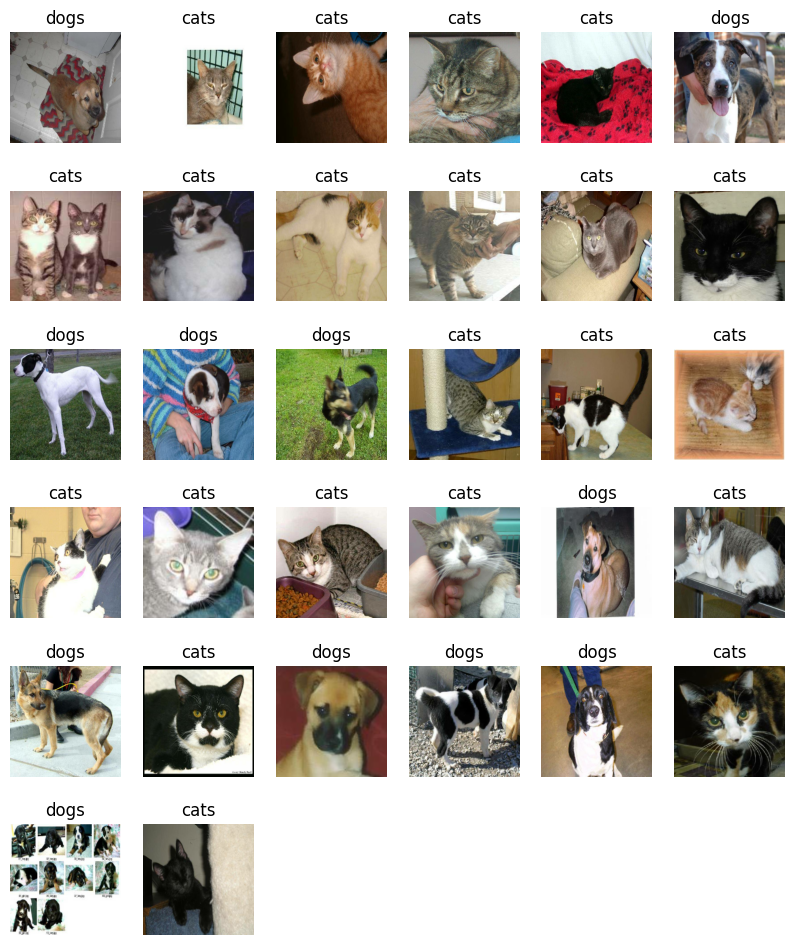

In [11]:
image_batch, label_batch = next(iter(test_set))  
show_batch(image_batch, label_batch.numpy())

## Prepare the model

### Load a model from tensorflow database

Large number of famous architectures (https://www.tensorflow.org/api_docs/python/tf/keras/applications) 

- include_top: Boolean, whether to include the fully-connected layer at the top of the network. Default to True.
- weights: One of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded. Default to 'imagenet'.

Inception and MobileNet were selected since they have the same pre processing.


In [12]:
def build_base_model(weights):

    if MODEL_NAME == 'InceptionResNetV2':

        base_model = tf.keras.applications.InceptionResNetV2( 
            input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), 
            include_top = False, weights=weights)

    elif MODEL_NAME == 'MobileNetV2':

        base_model = tf.keras.applications.MobileNetV2( 
            input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), 
            include_top = False, weights=weights)

    return base_model

base_model = build_base_model(None)
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

### Add new layers to the top of the network

Global Average Pooling (GAP) performs an average for each of the feature maps. Assuming the last conv layer is 3x3x256, we have 256 feature maps. Global average pooling is a layer with 256 values, each being the average of a feature map.

Original paper for Global Average Pooling: Network In Network, Min Lin1, Qiang Chen, Shuicheng Yan (https://arxiv.org/pdf/1312.4400.pdf). Note: GAP is not the main theme of the paper.

In [13]:
def build_model(base_model): 
    # start from the base model
    x = base_model.output
    # add a GAP layer
    x = layers.GlobalAveragePooling2D()(x)
    # hidden layer with 16 units
    x = layers.Dense(16, activation='relu')(x)
    # 2 is the number of classes
    x = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=x)

    return model

model = build_model(base_model)    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Train

### Prepare the model

In [14]:
file_path = create_weights_file_name('none') # f'{model_prefix}{MODEL_NAME}_train{DATA_SET_SIZE}_none_1_50_16/train/cp.ckpt'
callbacks = prepare_callbacks(file_path)

model.compile(optimizer='adam', loss='categorical_crossentropy', 
    metrics=[ 'accuracy'])


### Train 

To avoid training time we are going to read the weights of a pretrained model

Training took roughly 200 seconds per epoch on a GTX 1070 and stopped after 36 epochs

Evaluating the model on the test set took 4.72 seconds



In [15]:
if (TRAIN_ONLINE == True):
    history = model.fit(train_set, epochs=50, validation_data = val_set, callbacks = callbacks)



Epoch 1/50
705/705 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.6764
Epoch 1: val_accuracy improved from -inf to 0.59565, saving model to D:/vcpi/DL06/dogsvscats/InceptionResNetV2_train23000_none_1_50_16/train\cp.ckpt
705/705 [==============================] - 218s 137ms/step - loss: 0.6006 - accuracy: 0.6764 - val_loss: 0.6625 - val_accuracy: 0.5957 - lr: 0.0010
Epoch 2/50
705/705 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.7920
Epoch 2: val_accuracy improved from 0.59565 to 0.74565, saving model to D:/vcpi/DL06/dogsvscats/InceptionResNetV2_train23000_none_1_50_16/train\cp.ckpt
705/705 [==============================] - 213s 134ms/step - loss: 0.4508 - accuracy: 0.7920 - val_loss: 0.5194 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 3/50
705/705 [==============================] - ETA: 0s - loss: 0.3464 - accuracy: 0.8452
Epoch 3: val_accuracy improved from 0.74565 to 0.86739, saving model to D:/vcpi/DL06/dogsvscats/InceptionResNetV2_t

### Show how the learning progressed

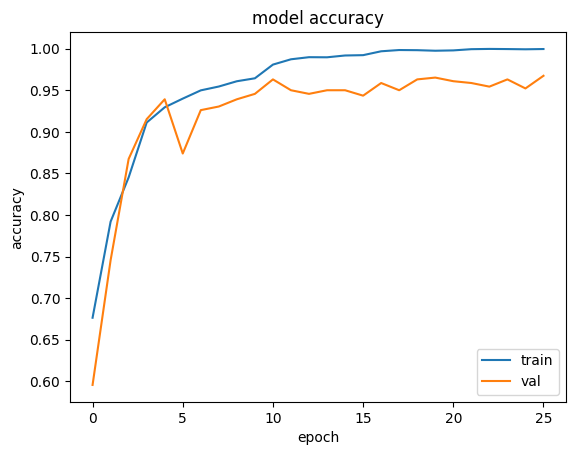

In [16]:
if (TRAIN_ONLINE):
    show_history(history.history['accuracy'], history.history['val_accuracy'])


### Evalute model on test set

In [17]:
model.load_weights(file_path)
eval = model.evaluate(test_set, verbose=2)
val = model.evaluate(val_set, verbose=2)
train = model.evaluate(train_set, verbose=2)


8/8 - 8s - loss: 0.1897 - accuracy: 0.9710 - 8s/epoch - 1s/step
2/2 - 1s - loss: 0.2091 - accuracy: 0.9674 - 885ms/epoch - 442ms/step
705/705 - 213s - loss: 3.3969e-04 - accuracy: 0.9999 - 213s/epoch - 302ms/step


## Transfer Learning

Model loading from Keras with weights from a training session on imagenet

In [18]:
base_model_i = build_base_model('imagenet')

### Freeze weights

In [19]:
base_model_i.trainable = False

### Add a head to the model

In [20]:
# # start from the base model
# x = base_model_i.output
# # add a GAP layer
# x = layers.GlobalAveragePooling2D()(x)
# # hidden layer with 16 units
# x = layers.Dense(16, activation='relu')(x)
# # 2 is the number of classes
# x = layers.Dense(2, activation='softmax')(x)

# model_i = models.Model(inputs=base_model_i.input, outputs=x)

model_i = build_model(base_model_i)
model_i.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

### Prepare the model

In [21]:
file_path_i = create_weights_file_name('imagenet') #f'{model_prefix}{MODEL_NAME}_train{DATA_SET_SIZE}_imagenet_1_50_16/train/cp.ckpt'
callbacks_i = prepare_callbacks(file_path_i)

model_i.compile(optimizer='adam', loss='categorical_crossentropy', 
    metrics=[ 'accuracy'])

### Train

In [22]:
if (TRAIN_ONLINE == True):
    history_i = model_i.fit(train_set, epochs=50, validation_data = val_set, callbacks = callbacks_i)

Epoch 1/50
704/705 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9885
Epoch 1: val_accuracy improved from -inf to 0.98696, saving model to D:/vcpi/DL06/dogsvscats/InceptionResNetV2_train23000_imagenet_1_50_16/train\cp.ckpt
705/705 [==============================] - 272s 145ms/step - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.0418 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 2/50
704/705 [============================>.] - ETA: 0s - loss: 0.0253 - accuracy: 0.9923
Epoch 2: val_accuracy did not improve from 0.98696
705/705 [==============================] - 188s 61ms/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.0260 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 3/50
704/705 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9927
Epoch 3: val_accuracy did not improve from 0.98696
705/705 [==============================] - 155s 59ms/step - loss: 0.0222 - accuracy: 0.9927 - val_loss: 0.0407 - val_accuracy: 0.9826 - lr: 0.0010
Epoch 4/50
705/

### Learning progression

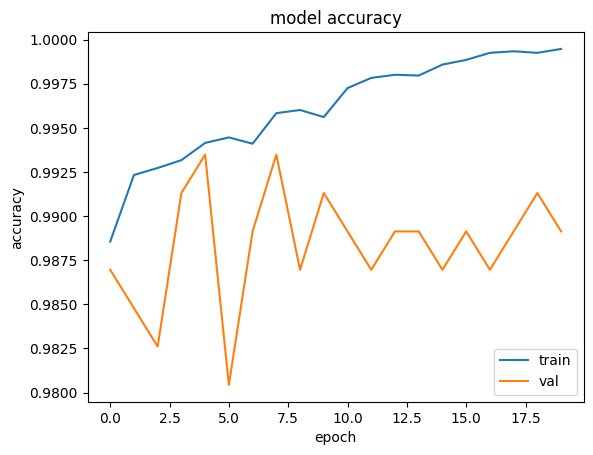

In [23]:
if (TRAIN_ONLINE):
    show_history(history_i.history['accuracy'], history_i.history['val_accuracy'])

In [24]:
model_i.load_weights(file_path_i)

### Evaluate on test set

In [25]:
eval_i = model_i.evaluate(test_set, verbose=2)
val_eval_i = model_i.evaluate(val_set, verbose=2)
train_eval_i = model_i.evaluate(train_set, verbose=2)

8/8 - 8s - loss: 0.0263 - accuracy: 0.9920 - 8s/epoch - 943ms/step
2/2 - 1s - loss: 0.0199 - accuracy: 0.9935 - 995ms/epoch - 498ms/step
705/705 - 140s - loss: 0.0131 - accuracy: 0.9962 - 140s/epoch - 199ms/step


### Compare accuracies on test set 

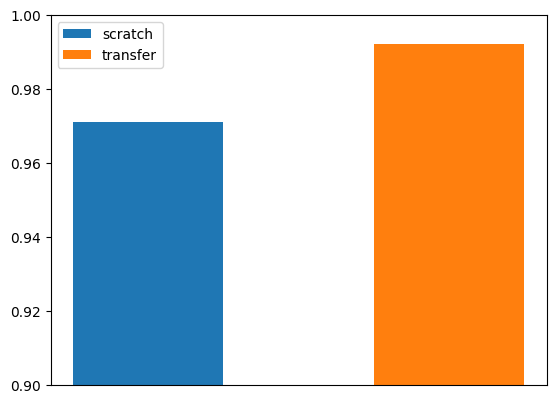

In [26]:
show_accuracy(['scratch', 'transfer'], [[eval[1]], [eval_i[1]]])

7/7 [==============================] - 4s 131ms/step


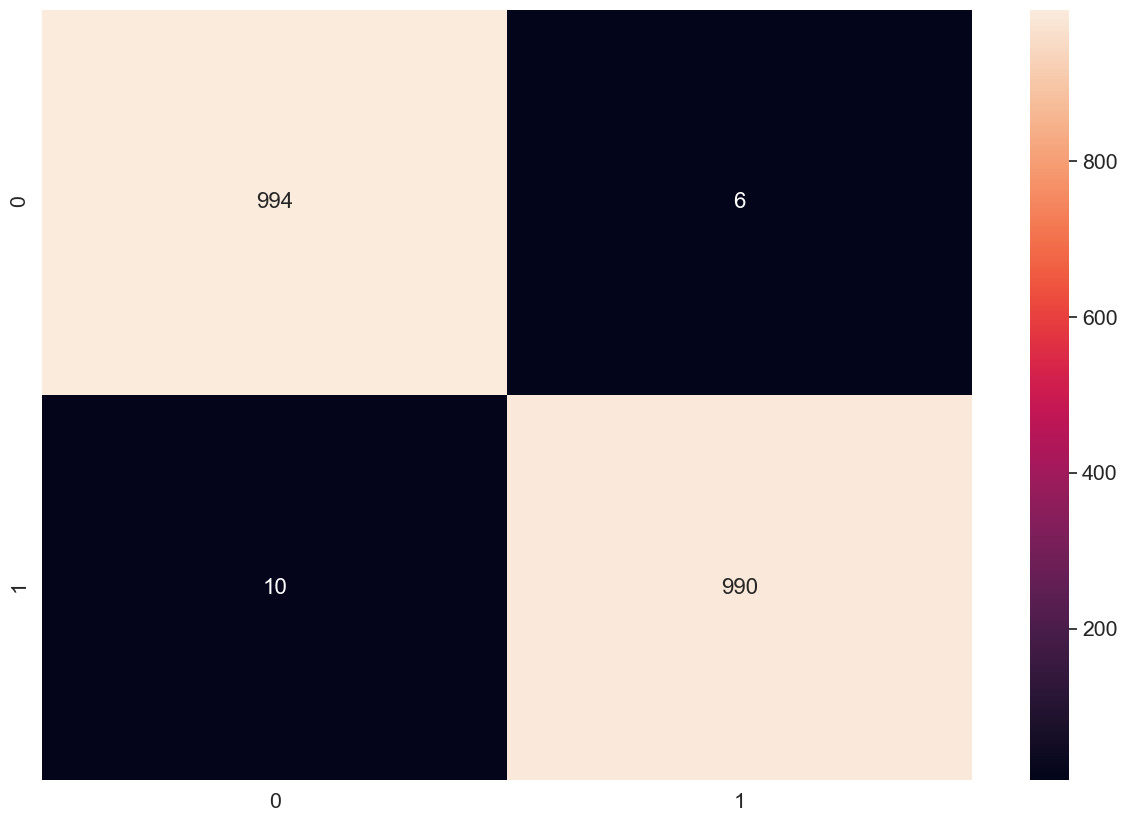

In [27]:
eval_and_show_confusion_matrix(model_i, test_set)

7/7 [==============================] - 0s 37ms/step
33


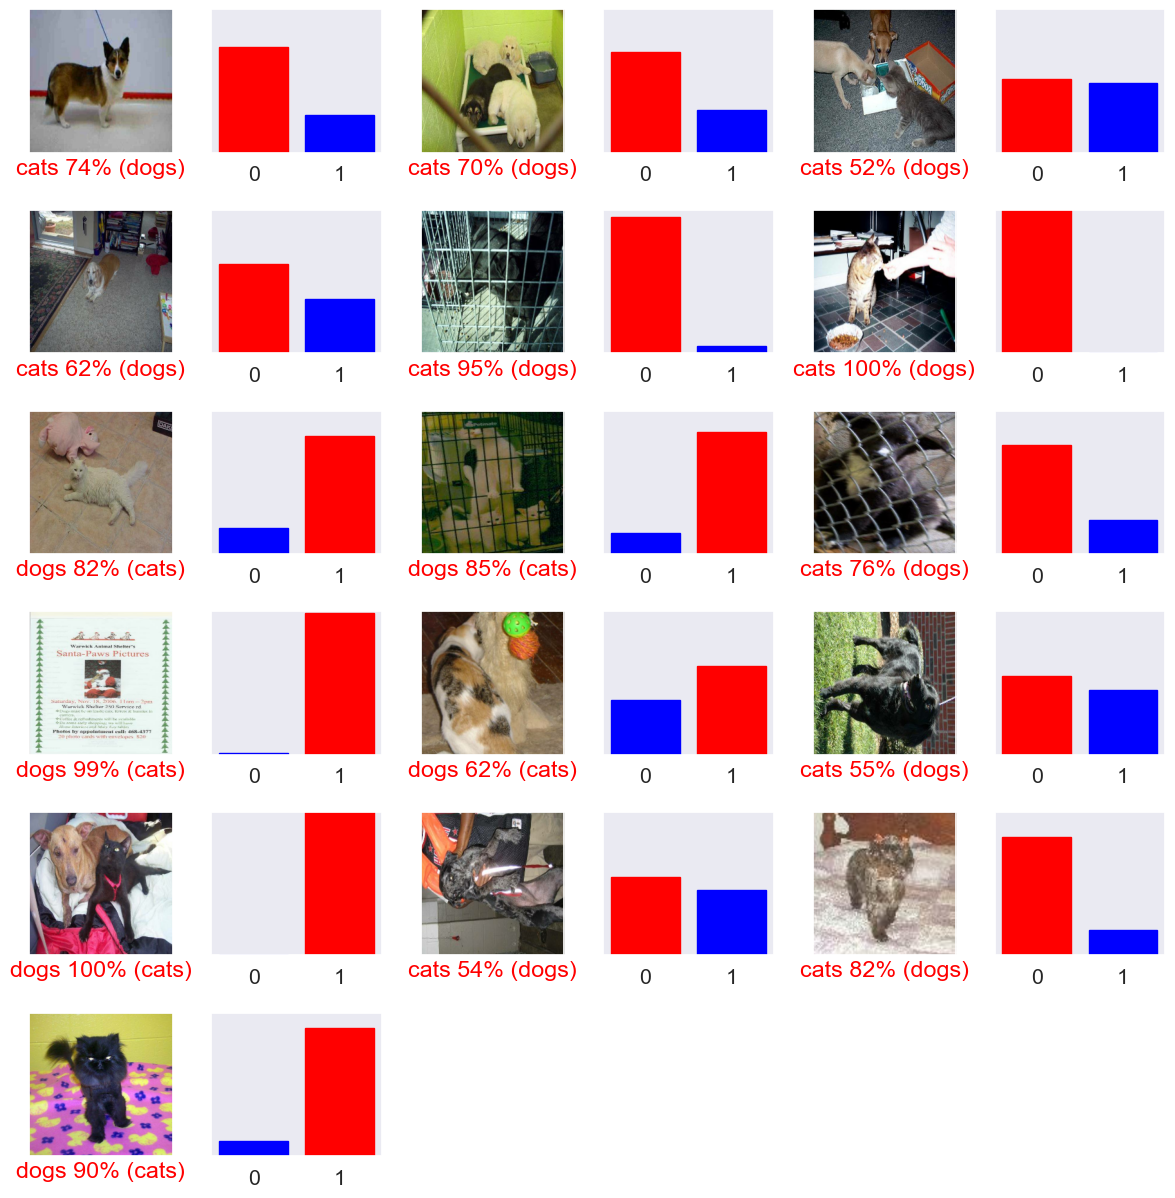

In [28]:
eval_and_show_misclassified(model_i, test_set, 11)

## Transfer Learning - Fine tunning

### Unfreeze the weights

In [29]:
# unfreeze last 50 layers (including the 3 top layers)
if MODEL_NAME == 'MobileNetV2':
    for layer in model_i.layers[98:]:  
        layer.trainable =  True
else:
    for layer in model_i.layers[:-50]:
        layer.trainable =  True
        
model_i.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

### New compilation is required

If model is not recompiled, then the trainable settings would not take effect

In [30]:
model_i.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', 
    metrics=[ 'accuracy'])

### Train the model to fine tune it

In [31]:
file_path_if = create_weights_file_name('imagenet', True) #f'{model_prefix}{MODEL_NAME}_train{DATA_SET_SIZE}_imagenet_1_50_16/train_ft/cp.ckpt'

if (TRAIN_ONLINE):
    callbacks_if = prepare_callbacks(file_path_if)
    history_if = model_i.fit(train_set, epochs=50, validation_data = val_set, callbacks = callbacks_if)


Epoch 1/50
705/705 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9777
Epoch 1: val_accuracy improved from -inf to 0.98696, saving model to D:/vcpi/DL06/dogsvscats/InceptionResNetV2_train23000_imagenet_1_50_16/train_ft\cp.ckpt
705/705 [==============================] - 237s 165ms/step - loss: 0.0568 - accuracy: 0.9777 - val_loss: 0.0530 - val_accuracy: 0.9870 - lr: 1.0000e-05
Epoch 2/50
705/705 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9952
Epoch 2: val_accuracy improved from 0.98696 to 0.99130, saving model to D:/vcpi/DL06/dogsvscats/InceptionResNetV2_train23000_imagenet_1_50_16/train_ft\cp.ckpt
705/705 [==============================] - 247s 162ms/step - loss: 0.0141 - accuracy: 0.9952 - val_loss: 0.0498 - val_accuracy: 0.9913 - lr: 1.0000e-05
Epoch 3/50
705/705 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9988
Epoch 3: val_accuracy did not improve from 0.99130
705/705 [==============================] -

In [32]:
model_i.load_weights(file_path_if)

In [33]:
eval_if = model_i.evaluate(test_set, verbose=2)
val_if = model_i.evaluate(val_set, verbose=2)
train_if = model_i.evaluate(train_set, verbose=2)


8/8 - 8s - loss: 0.0588 - accuracy: 0.9875 - 8s/epoch - 1s/step
2/2 - 1s - loss: 0.0498 - accuracy: 0.9913 - 1s/epoch - 637ms/step
705/705 - 115s - loss: 0.0307 - accuracy: 0.9939 - 115s/epoch - 163ms/step
